In [1]:
import vae
from model import Model
from pytorch_lightning import Trainer
import yaml
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pathlib import Path
from dataloader import Dataset
from pytorch_lightning.plugins import DDPPlugin
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision.utils import make_grid
import torchvision.transforms as T
from torchvision.transforms.functional import to_pil_image
import torch
from math import e


/home/sonia/miniconda3/envs/py/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# interpret given hyperparameters
with open('./conf/model/betavae.yaml', 'r') as file:
    modelconfig = yaml.safe_load(file)

with open('./conf/data/celeba.yaml', 'r') as file:
    dataconfig = yaml.safe_load(file)
    modelconfig['model_params']['in_channels'] = dataconfig['in_channels']

In [3]:
vae = vae.beta_vae(**modelconfig['model_params'])
experiment = Model(vae, modelconfig['exp_params'])
checkpoint = torch.load('logs/betavae/version_3/checkpoints/last.ckpt')
experiment.load_state_dict(checkpoint['state_dict'])

/home/sonia/miniconda3/envs/py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/sonia/miniconda3/envs/py/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `FrechetInceptionDistance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


<All keys matched successfully>

In [4]:
data = Dataset(**dataconfig, pin_memory=len(modelconfig['trainer_params']['gpus']) != 0)
data.setup()
test = data.test_dataloader()

Files already downloaded and verified
Files already downloaded and verified


In [5]:
ex, label = next(iter(test)) #get random batch
print(ex.shape,label.shape)

torch.Size([144, 3, 64, 64]) torch.Size([144, 40])


In [6]:
mu, var = vae.encode(ex)
print(mu.shape, var.shape) #examples X latent dims

torch.Size([144, 8]) torch.Size([144, 8])


In [7]:
decode, _, mu, log_var = vae.forward(ex)

In [8]:
im=decode

## Try each dimension seperately

In [15]:
dims = var.shape[1]
ims=[]
for d in range(dims):
    print(d)
    mum = mu
    mum[:,d]=mum[:,d]-e**(log_var[:,d])
    zm =vae.reparameterize(mum, log_var)
    imm=vae.decode(zm)
    
    mup = mu
    mup[:,d]=mup[:,d]+e**(log_var[:,d])
    zp =vae.reparameterize(mup, log_var)
    imp=vae.decode(zp)

    ims = ims + [imm, im, imp]

0
1
2
3
4
5
6
7


In [16]:
for ex in range(im.shape[0]):
    res=to_pil_image(make_grid( [T.Resize(256)(i[ex]) for i in ims], nrow=3 ))
    res.save(f'exs/betavae{ex}.png')

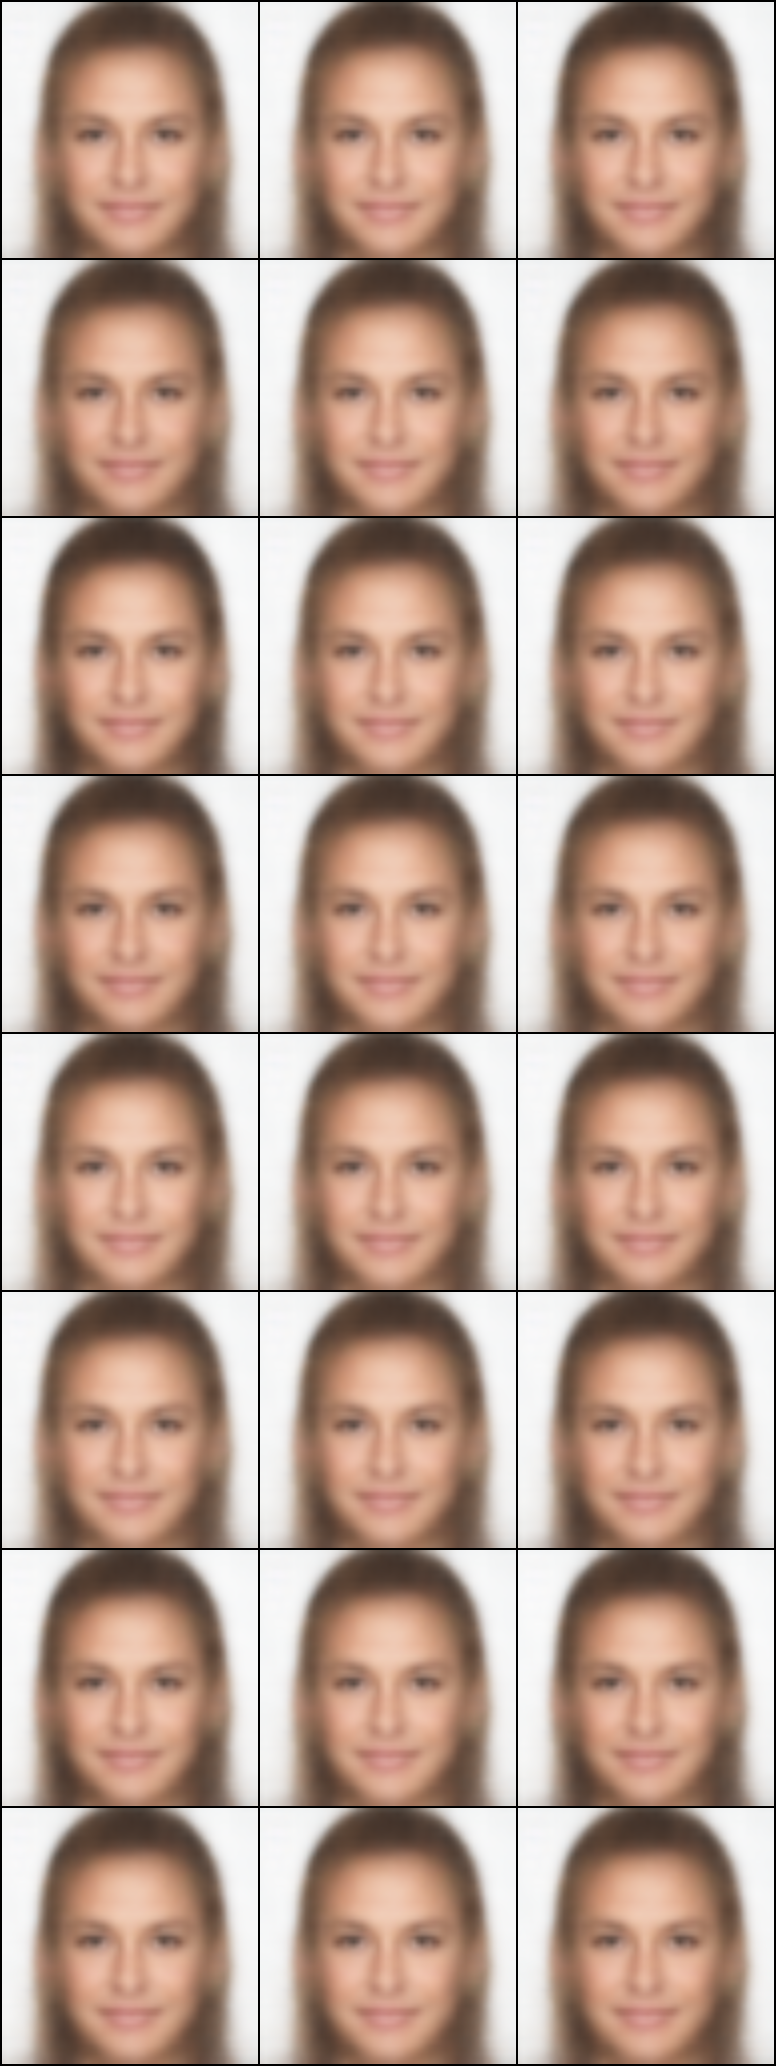

In [17]:
res